# **Fit GLM to dmdm data**
---
We first fit normal GLM to the dataset. One of differences between our dmdm dataset and IBL dataset is that we have two observations of animal behavior: choice outcome `y` and reaction time `rt`. Here, we fit those two observation independently by simply using two separate GLMs.

## **HPC setting**
Ashwood's original script is written in python scirpts. Here, we rewrite it in Jupyter to make it more user-friendly to run on HPC with `dask`. [This](https://github.com/pierreglaser/hpc-tutorial/tree/main) is very useful resource to get familiar with `dask`. You can skip these if you are only using one node (which is usually the case when nodes are occupied.)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Allocate the computing resources
from dask_jobqueue import SLURMCluster
from distributed import Client
from joblib import Memory, Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits

cluster = SLURMCluster(
    workers=0,      # create the workers "lazily" (upon cluster.scal)
    memory='32g',   # amount of RAM per worker
    processes=1,    # number of execution units per worker (threads and processes)
    cores=1,        # among those execution units, number of processes
    # a lazy trick to avoid matplotlib crash with parallel plotting
    walltime="48:00:00",
    worker_extra_args=["--resources GPU=1"], # the only way to add GPUs
    local_directory='/nfs/nhome/live/skuroda/jobs', # set your path to save log
    log_directory='/nfs/nhome/live/skuroda/jobs' # set your path to save log
)   

memory = Memory('/nfs/nhome/live/skuroda/joblib-cache') # set your path

n = 8
cluster.scale(n)
client = Client(cluster)
print(client.dashboard_link)

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/

http://192.168.234.52:8787/status


## **GLM fitting**
---
At this step, we remove abort trials from the model. Abort trials are hard to predict and often ends up with unstable weights, which is the last thing we want to have. Hence the number of behavioral outcomes: `C = 3`.

In [3]:
# ------- load modules -------
import autograd.numpy as np
import autograd.numpy.random as npr

from glm_utils import fit_glm, fit_glm_runml, fit_RT_glm, \
                      plot_input_vectors, plot_logOR_hit_vs_miss, plot_rt_weights, plot_lls
import sys
sys.path.insert(0, '../') # a lazy trick to search parent dir
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
from data_io import get_file_dir, load_session_fold_lookup, load_data, load_animal_list
from data_labels import create_abort_mask
from functools import partial
from collections import OrderedDict

In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

In [4]:
# ------- setup variables -------
dname = 'dataAllHumans'
num_folds = 1

C = 3  # number of output types/categories. Hit/FA/Miss
nested_outcome = OrderedDict() # define nested structure for behavioral outcomes
nested_outcome["Baseline"] = [2]
nested_outcome["Change"] = [0, 1]

N_initializations = 10
labels_for_plot_y = ['CSize', 'COnset', 'Outcome +1', 'Outcome +2', 'Outcome +3', 'Outcome +4', 'Outcome +5', 'bias']
labels_for_plot_rt = ['CSize', 'COnset', 
                      'PrevHowDeviant?',
                      'PrevCOnset', 'PrevRT','bias']
labels_for_plot = {'y':labels_for_plot_y, 'rt':labels_for_plot_rt}
npr.seed(65)  # set seed in case of randomization

## **Fit GLM to all animals**
---
We fit GLMs on both `y` (outcomes) and `rt` (reaction times). In the outcome-predicting GLM, each dependent variables is assumed to be generated from a multinominal distribution. On the other hand, reaction-time-predicting GLM expects dependent variables to follow a gaussian distribution.

In [5]:
# ------- setup path and load data -------
data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'
# Create directory for results:
results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit" / dname
results_dir.mkdir(parents=True, exist_ok=True)

animal_file = data_dir / 'all_animals_concat.npz'
inpt_y, inpt_rt, y, session, rt, stim_onset = load_data(animal_file)
session_fold_lookup_table = load_session_fold_lookup(
    data_dir / 'all_animals_concat_session_fold_lookup.npz')

In [6]:
def fit_GLM_y(inpt_y, y, session, session_fold_lookup_table, results_dir, labels_for_plot, nested_outcome, fold):
    # Subset to relevant covariates for covar set of interest:
    y = y.astype('int')
    figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
    figure_directory.mkdir(parents=True, exist_ok=True)

    # Subset to sessions of interest for fold
    sessions_to_keep = session_fold_lookup_table[np.where(
        session_fold_lookup_table[:, 1] != fold), 0]
    idx_this_fold = [
        str(sess) in sessions_to_keep for id, sess in enumerate(session)
    ]
    this_inpt_y, this_y, this_session = inpt_y[idx_this_fold, :], y[
        idx_this_fold, :], session[idx_this_fold]
    train_size = this_inpt_y.shape[0]

    # Identify abort trials for exclusion:
    abort_idx = np.where(this_y == 3)[0]
    nonviolation_idx, mask = create_abort_mask(abort_idx, this_inpt_y.shape[0])

    M = this_inpt_y.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly

        # Only do this so that errors are avoided - these y values will not
        # actually be used for anything (due to violation mask)
        this_y[np.where(this_y == 3), :] = 2

        loglikelihood_train, recovered_weights, fit_ll = fit_glm([this_inpt_y],
                                                                 [this_y], 
                                                                 M, 
                                                                 C,
                                                                 [mask],
                                                                 nested_outcome)
        plot_input_vectors(recovered_weights,
                           figure_directory,
                           title="GLM fit; Final LL = " +
                           str(loglikelihood_train),
                           save_title='init' + str(iter),
                           labels_for_plot=labels_for_plot)
        plot_logOR_hit_vs_miss(recovered_weights,
                               figure_directory,
                               title="GLM fit; Final LL = " +
                               str(loglikelihood_train),
                               save_title='init' + str(iter),
                               labels_for_plot=labels_for_plot)
        plot_lls(fit_ll, figure_directory, save_title='y_init' + str(iter))
        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory / ('GLM_y_variables_of_interest_iter_' + str(iter) + '.npz'), 
            loglikelihood_train, recovered_weights)
        

fit_GLM_y_eachfold = partial(fit_GLM_y, inpt_y, y, session, session_fold_lookup_table, results_dir, labels_for_plot['y'], nested_outcome)        
fit_GLM_y_eachfold_cached = memory.cache(fit_GLM_y_eachfold)

In [7]:
def fit_GLM_rt(inpt_rt, rt, stim_onset, y, session, session_fold_lookup_table, results_dir, labels_for_plot, nested_outcome, fold):
    # Subset to relevant covariates for covar set of interest:
    figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
    figure_directory.mkdir(parents=True, exist_ok=True)

    # Subset to sessions of interest for fold
    sessions_to_keep = session_fold_lookup_table[np.where(
        session_fold_lookup_table[:, 1] != fold), 0]
    idx_this_fold = [
        str(sess) in sessions_to_keep for id, sess in enumerate(session)
    ]
    this_inpt_rt, this_rt, this_stim_onset, this_y, this_session = \
          inpt_rt[idx_this_fold, :], rt[idx_this_fold, :], stim_onset[idx_this_fold, :], y[
          idx_this_fold, :], session[idx_this_fold]
    train_size = this_inpt_rt.shape[0]

    # Identify abort trials for exclusion:
    abort_idx = np.where(this_y == 3)[0]
    nonviolation_idx, mask = create_abort_mask(abort_idx, this_inpt_rt.shape[0])

    M = this_inpt_rt.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly

        loglikelihood_train, recovered_weights, fit_ll = fit_RT_glm([this_inpt_rt],
                                                                    [this_rt], 
                                                                    [this_stim_onset],
                                                                    M,
                                                                    [mask])
        plot_rt_weights(recovered_weights,
                           figure_directory,
                           title="GLM fit; Final LL = " +
                           str(loglikelihood_train),
                           save_title='init' + str(iter),
                           labels_for_plot=labels_for_plot)
        plot_lls(fit_ll, figure_directory, save_title='rt_init' + str(iter))
        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory / ('GLM_rt_variables_of_interest_iter_' + str(iter) + '.npz'), 
            loglikelihood_train, recovered_weights)
        
fit_GLM_rt_eachfold = partial(fit_GLM_rt, inpt_rt, rt, stim_onset, y, session, session_fold_lookup_table, results_dir, labels_for_plot['rt'], nested_outcome)        
fit_GLM_rt_eachfold_cached = memory.cache(fit_GLM_rt_eachfold)

In [8]:
with Client(cluster) as client: # upload local functions to each worker. They cannot read them with sys.append or sys.insert.
    client.wait_for_workers(n)
    client.upload_file(str(get_file_dir() / 'data_labels.py'))

In [9]:
%%time

with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=120):
        Parallel(verbose=100)(delayed(fit_GLM_y_eachfold)(fold) for fold in range(num_folds))
        # Parallel(verbose=100)(delayed(fit_GLM_rt_eachfold)(fold) for fold in range(num_folds))
        # using cached function should improve the performance to some extent...
        # I am not using it because it hides the name of ongoing process in Dask's progress bar

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.


IndexError: arrays used as indices must be of integer (or boolean) type

[[[ 1.19968430e+01 -8.93647803e-01 -8.15974793e-01 -8.53032879e-01
    4.56886132e-01 -7.00516148e-02 -1.86120697e+00  9.82135084e-01]
  [ 1.33405826e+01 -1.00470223e+00 -9.56547320e-02 -3.65924088e-01
    7.55368354e-01  2.01094513e-01 -1.53691055e+00  1.80178329e-01]
  [-2.63939619e+01 -3.92459528e-01  3.50903982e-03 -1.89587412e-01
    8.46463891e-01  3.03171131e-01 -1.37888796e+00  9.26977305e-01]]]


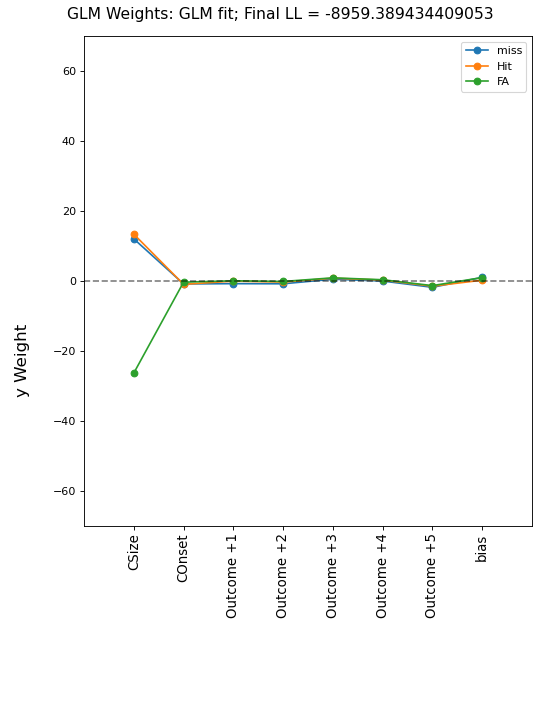

In [10]:
# Plot some results for y
from IPython.display import Image
example_npz_loc = str(results_dir / "GLM" / "fold_4" / 'GLM_y_variables_of_interest_iter_0.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_dir / "GLM" / "fold_4" / 'y_glm_weights_init0.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

## **Fit GLM to each animal separately**
---
We next fit GLMs to each animal. Each animal's behavior is different from each other, and there is always a chance that GLM weights end up being also different between animals.

In [11]:
# ------- setup path and load data -------
data_2_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster' / "data_by_animal"
# Create directory for results:
results_2_dir = get_file_dir().parents[1] / "results" / "dmdm_individual_fit" / dname
results_2_dir.mkdir(parents=True, exist_ok=True)

animal_list = load_animal_list(data_2_dir / 'animal_list.npz')

In [12]:
def fit_GLM_separately(data_2_dir, results_2_dir, labels_for_plot: dict, nested_outcome, num_folds, animal):
    # Fit GLM to data from single animal:
    animal_file = data_2_dir / (animal + '_processed.npz')
    session_fold_lookup_table = load_session_fold_lookup(
        data_2_dir / (animal + '_session_fold_lookup.npz'))
    this_results_dir = results_2_dir / animal

    # Load data
    print(str(animal_file))
    inpt_y, inpt_rt, y, session, rt, stim_onset = load_data(animal_file)

    for fold in range(num_folds):
        fit_GLM_y(inpt_y, y, session, session_fold_lookup_table, this_results_dir, labels_for_plot['y'], nested_outcome, fold)
        fit_GLM_rt(inpt_rt, rt, stim_onset, y, session, session_fold_lookup_table, this_results_dir, labels_for_plot['rt'], nested_outcome, fold)
            
fit_GLM_separately_eachanimal = partial(fit_GLM_separately, data_2_dir, results_2_dir, labels_for_plot, nested_outcome, num_folds)     
fit_GLM_separately_eachanimal_cached = memory.cache(fit_GLM_separately_eachanimal)


In [13]:
with Client(cluster) as client: # upload local functions to each worker. They cannot read them with sys.append or sys.insert.
    client.wait_for_workers(n)
    client.upload_file(str(get_file_dir() / 'data_io.py'))
    client.upload_file(str(get_file_dir() / 'data_labels.py'))

In [14]:
%%time
with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=120):
        Parallel(verbose=100)(delayed(fit_GLM_separately_eachanimal_cached)(animal) for animal in animal_list)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed: 18.3min remaining: 36.7min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 18.4min remaining: 18.4min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 18.5min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 19.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 19.8min finished
CPU times: user 1min 18s, sys: 4.59 s, total: 1min 22s
Wall time: 19min 46s


[[[  8.98409111  -0.16390039  -0.75966947  -0.98129986  -0.20421415
    -1.14916443   0.54390118   1.10400874]
  [ 10.34072293  -0.3621007   -0.03176238  -0.47138517   0.04363812
    -0.877629     0.87904741   0.35877817]
  [-19.29099421   0.53527902  -0.11887252  -0.56542844   0.02001055
    -0.92346256   0.5656209   -1.21208742]]]


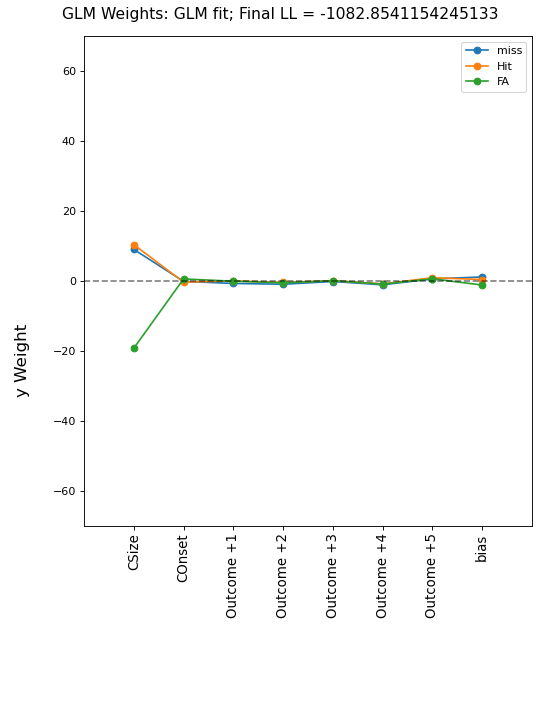

In [15]:
# Plot some results for y
from IPython.display import Image
example_npz_loc = str(results_2_dir / 'x1108393' / "GLM" / "fold_4" / 'GLM_y_variables_of_interest_iter_0.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_2_dir / 'x1108393' / "GLM" / "fold_4" / 'y_glm_weights_init0.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

In [16]:
# Once finished, shut down the cluster and the client
cluster.close()
client.close()

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gon

In [17]:
from kfold_cv import KFoldCV
from data_io import load_data, load_session_fold_lookup, load_glmhmm_data, load_cv_arr, get_file_name_for_best_glmhmm_fold, get_best_map_params
from data_postprocessing_utils import calculate_state_permutation
sys.path.append('../../../3_make_figures/dmdm/')
from plot_model_perform import plot_states, plot_model_comparison, plot_state_occupancy
import json

model = 'GLM_y'
labels_for_plot_y = ['CSize', 'COnset', 'PrevHowDeviant?', 'bias']
print('Animals for individual fitting: {}'.format(animal_list))

Animals for individual fitting: ['x1108393' 'x1116760' 'x1116765' 'x1117910' 'x1119408' 'x1119541']


In [18]:
for animal in animal_list:
    print(animal)
    this_results_dir = results_2_dir / animal

    animal_file = data_2_dir / (animal + '_processed.npz')
    session_fold_lookup_table = load_session_fold_lookup(
        data_2_dir / (animal + '_session_fold_lookup.npz'))
    inpt_y, inpt_rt, y, session, rt, stim_onset = load_data(animal_file)

    KFCV = KFoldCV(model, num_folds, results_dir=this_results_dir, animal=animal)
    KFCV.save_best_iter(inpt_y, inpt_rt, y, session, rt, stim_onset,
                         session_fold_lookup_table, C, outcome_dict=nested_outcome)


x1108393
Retrieving best iter results for model = GLM_y; num_folds = 5


100%|███| 5/5 [00:00<00:00,  6.80it/s]


Best init saved!
x1116760
Retrieving best iter results for model = GLM_y; num_folds = 5


100%|███| 5/5 [00:00<00:00,  9.16it/s]


Best init saved!
x1116765
Retrieving best iter results for model = GLM_y; num_folds = 5


100%|███| 5/5 [00:00<00:00, 10.16it/s]


Best init saved!
x1117910
Retrieving best iter results for model = GLM_y; num_folds = 5


100%|███| 5/5 [00:00<00:00,  9.52it/s]


Best init saved!
x1119408
Retrieving best iter results for model = GLM_y; num_folds = 5


100%|███| 5/5 [00:00<00:00,  9.29it/s]


Best init saved!
x1119541
Retrieving best iter results for model = GLM_y; num_folds = 5


100%|███| 5/5 [00:00<00:00,  9.71it/s]

Best init saved!


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
